In [1]:
import catalyst
from catalyst import qjit

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, OptimizeResult

import jax.numpy as jnp

In [2]:
## Layers and wires for circuits

symbols = ["Li", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

# Building the molecular hamiltonian for LiH
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method="pyscf",
)

LAYERS = 1
WIRES = qubits

## https://docs.pennylane.ai/projects/catalyst/en/latest/code/api/catalyst.grad.html - ["fd", "ps", "adj"]
GRADIENT_METHOD= "fd"

TRAINING_ENERGIES= {"gradient_descent":{"energies":[], "trained_meta_vars":[]},
                    "spsa":{"energies":[], "trained_meta_vars":[]},
                    "adam":{"energies":[], "trained_meta_vars":[]},
                   }

# Encoder: 
# Linear -> 1
# Gaussian -> 2

ENCODER_MULTIPLIER_DICT = {1:2,
                      2:4}

ENCODER = 1

shared_dev = qml.device("lightning.qubit", wires=WIRES)

symbols = ["Li", "H"]

train_points = [1.0,2.0,3.0,4.0,5.0]

test_points = np.arange(0.6,6,0.2)


In [3]:
def linear_encoding(param_array, r):
    """1-D array with alphas and betas. len(param_array) = 2 * len(weights) 

    Args:
        param_array (float): alphas and betas for lineasr encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """
    return param_array[::2]*r + param_array[1::2]

In [4]:
def gaussian_encoding(param_array, r):
    """1-D array with alphas, betas, gammas and deltas. len(param_array) = 4 * len(weights) 

    Args:
        param_array (float): , betas, gammas and deltas for gaussian encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """

    exp_arg = param_array[1::4]*[i-r for i in param_array[2::4]]

    return param_array[::4]*np.exp(exp_arg) + param_array[3::4]

In [5]:
## Get shapes

## For linear is 2
## For Gaussian is 4
ENCODING_MULTIPLIER= ENCODER_MULTIPLIER_DICT[ENCODER]

if(ENCODER == 1):
    ENCODER_FUNC =linear_encoding
else:
    ENCODER_FUNC =gaussian_encoding

num_params = (WIRES + LAYERS*(WIRES-1)*2)*ENCODING_MULTIPLIER

shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=WIRES)
weights = np.random.random(num_params)

print("===== NUM OF PARAMETERS =====")
print(num_params)

===== NUM OF PARAMETERS =====
68


In [6]:
##Run for all points without training

@qml.qnode(shared_dev)
def catalyst_simplified_two_design(params, d):

    coordinates = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, d])

    # Building the molecular hamiltonian for LiH
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        method="pyscf",
    )    

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)

    init_weights, weights = np.reshape(params[:qubits],shapes[0]), np.reshape(params[qubits:],shapes[1])

    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

    return qml.expval(
        qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
    )  

In [7]:
from jax.core import ShapedArray

@qjit
def energy_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    energies = []   

    for r in train_points:
   
        def catalyst_simplified_two_design(params):
        
            symbols = ["Li", "H"]
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(catalyst_simplified_two_design, shared_dev)
        
        energies.append(circuit(params))
        
    join_energy = jnp.sum(jnp.array(energies))


    
    return join_energy/len(train_points) 

[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 2.]
[0. 0. 0. 0. 0. 3.]
[0. 0. 0. 0. 0. 4.]
[0. 0. 0. 0. 0. 5.]


In [8]:
from jax.core import ShapedArray

@qjit
def gradient_simplified_two_design(params: ShapedArray(shape=(num_params,), dtype=jnp.float64)):

    gradients = []

    for r in train_points:
   
        def catalyst_simplified_two_design(params):
        
            symbols = ["Li", "H"]
            coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])     
            
            # Building the molecular hamiltonian for LiH
            hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
                symbols,
                coordinates,
                method="pyscf",
            )
            
            print(coordinates)           
            
            shapes = qml.SimplifiedTwoDesign.shape(n_layers=LAYERS, n_wires=qubits)   

            weights_encoded =  ENCODER_FUNC(params, r)       

            init_weights, weights = np.reshape(weights_encoded[:qubits],shapes[0]), np.reshape(weights_encoded[qubits:],shapes[1])

            qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(qubits))

            return qml.expval(
                qml.Hamiltonian(np.array(hamiltonian.coeffs), hamiltonian.ops)
            )  
                
        circuit = qml.QNode(catalyst_simplified_two_design, shared_dev)
        
        gradients.append(catalyst.grad(circuit, method = GRADIENT_METHOD )(params))
        
    all_gradients = jnp.array(gradients)
    joined_gradients = jnp.sum(jnp.array([all_gradients[i][0] for i in range(len(all_gradients))]), axis=0)

    
    return joined_gradients/len(train_points)

[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 2.]
[0. 0. 0. 0. 0. 3.]
[0. 0. 0. 0. 0. 4.]
[0. 0. 0. 0. 0. 5.]


In [9]:
energy_simplified_two_design(weights)


Array(-3.54072287, dtype=float64)

In [10]:
gradient_simplified_two_design(weights)

Array([-1.42117038e+00, -6.85109358e-01,  1.97627352e-01,  1.72943967e-01,
        2.88188492e-01,  7.60647412e-02,  1.69826443e-01, -1.61914659e-03,
        6.30699113e-01,  1.59884190e-01, -7.90840957e-02, -4.61269778e-02,
       -7.22479180e-01, -1.20229323e-01, -1.66283938e-02,  2.49151526e-02,
        3.89888000e-01,  1.30226621e-01,  5.47352110e-02, -9.39492129e-03,
       -4.42430885e-01, -1.95844186e-01,  8.30781843e-03,  5.95978777e-02,
        2.07840897e+00,  5.30212175e-01, -8.31628769e-01, -3.52813516e-01,
       -5.03028019e-03,  8.84539553e-03,  3.95681984e-01,  1.05311817e-01,
       -4.57867690e-01, -7.76906735e-02, -4.14332172e-01, -9.58051753e-02,
        6.82469299e-02, -7.87960719e-03,  1.89463117e-01,  4.05699510e-02,
       -3.26147592e-01, -7.36115000e-02,  3.11843307e-02,  3.75436482e-03,
       -2.41261903e-01, -1.13368959e-01,  6.61654029e-02,  4.49806006e-02,
       -5.79301481e-01, -1.46749271e-02, -3.39445035e-01, -9.81895116e-02,
        4.76792117e-02,  

In [11]:
def gradient_descent(fun,x0, stepsize=0.1, tol=1e-4,maxiter=100, verbose = False, **options):

    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]    

    niter = 0

    for i in range(maxiter):
        niter +=1
        grad = gradient_simplified_two_design(new_params)

        new_params -= grad*stepsize

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)
        
        if(verbose and i%10 == 0):
            print("Gradient Descent - Step: ", i, " Cost: ", new_energy)

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["gradient_descent"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["gradient_descent"]["trained_meta_vars"].append(new_params)
    
    print("Finished Gradient Descent training")

    return OptimizeResult(x=new_params, nit=niter)


In [12]:
def spsa_optimizer(fun, x0, maxiter=100,alpha=0.602,gamma=0.101, c=0.2, A=None, a=None, tol=1e-4, verbose = False, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy]       

    if not A:
        A = maxiter * 0.1

    if not a:
        a = 0.05 * (A + 1) ** alpha        

    niter = 0

    for i in range(maxiter):
        niter +=1

        ak=a/np.power(i+1+A,alpha)
        ck=c/np.power(i+1,gamma)

        delta = np.random.choice([-1, 1], size=x0.shape)

        thetaplus=new_params+ck*delta
        thetaminus=new_params-ck*delta
        yplus=energy_simplified_two_design(thetaplus)
        yminus=energy_simplified_two_design(thetaminus)  

        grad = jnp.array([(yplus - yminus) / (2 * ck * di) for di in delta]  )

        new_params -= ak*grad

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)  
        
        if(verbose and i%10 == 0):
            print("SPSA - Step: ", i, " Cost: ", new_energy)        

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["spsa"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["spsa"]["trained_meta_vars"].append(new_params)  
    
    print("Finished SPSA training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [13]:
def adam(fun, x0, maxiter=100,stepsize=0.01, beta1=0.9, beta2=0.99, tol=1e-4,eps=1e-08, verbose = False, **options):
    new_params = jnp.array(x0)
    ref_energy = energy_simplified_two_design(new_params)
    
    energy_evolution = [ref_energy] 
      
    m = jnp.zeros_like(x0)
    v = jnp.zeros_like(x0)

    niter = 0

    for i in range(maxiter):
        niter +=1

        grad = gradient_simplified_two_design(new_params)

        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*jnp.square(grad)

        mhat = m/(1-beta1**(i+1))

        vhat = v/(1-beta2**(i+1))

        step = mhat/(jnp.array([np.sqrt(vhat_i) + eps for vhat_i in vhat]) )


        new_params -= stepsize*step

        new_energy = energy_simplified_two_design(new_params)
        
        energy_evolution.append(new_energy)     
        
        if(verbose and i%10 == 0):
            print("ADAM - Step: ", i, " Cost: ", new_energy)        

        if(np.abs(new_energy-ref_energy) < tol):
            break
        else:
            ref_energy = new_energy
            
    TRAINING_ENERGIES["adam"]["energies"].append(energy_evolution)
    TRAINING_ENERGIES["adam"]["trained_meta_vars"].append(new_params)  
    
    print("Finished ADAM training")
    

    return OptimizeResult(x=new_params, nit=niter)    

In [14]:
res_gradient = minimize(energy_simplified_two_design, weights, method = gradient_descent, options = {'maxiter': 200, 'tol':1e-6, 'verbose':True})
res_spsa = minimize(energy_simplified_two_design, weights, method = spsa_optimizer, options = {'maxiter': 200, 'tol':1e-6, 'verbose':True})
res_adam = minimize(energy_simplified_two_design, weights, method = adam, options = {'maxiter': 200, 'tol':1e-6, 'verbose':True})

Step:  0  Cost:  -4.494265679809889
Step:  1  Cost:  -4.8431918603776145
Step:  2  Cost:  -5.1127075613172845
Step:  3  Cost:  -5.337149947494096
Step:  4  Cost:  -5.511755188657186
Step:  5  Cost:  -5.661435247944451
Step:  6  Cost:  -5.770301734810663
Step:  7  Cost:  -5.807259385840635
Step:  8  Cost:  -5.770804611436661
Step:  9  Cost:  -5.6497534219802406
Step:  10  Cost:  -5.655822217813705
Step:  11  Cost:  -5.651447425140882
Step:  12  Cost:  -5.74854500959916
Step:  13  Cost:  -5.826001975588542
Step:  14  Cost:  -5.919065822404969
Step:  15  Cost:  -6.000581964277343
Step:  16  Cost:  -6.050003911243715
Step:  17  Cost:  -6.101484670818164
Step:  18  Cost:  -6.144126838930168
Step:  19  Cost:  -6.182483349952885
Step:  20  Cost:  -6.225146010382092
Step:  21  Cost:  -6.256027665752977
Step:  22  Cost:  -6.2915151244423955
Step:  23  Cost:  -6.316430629222784
Step:  24  Cost:  -6.346216183021142
Step:  25  Cost:  -6.36687987692882
Step:  26  Cost:  -6.393989752202441
Step:  27

<function matplotlib.pyplot.show(close=None, block=None)>

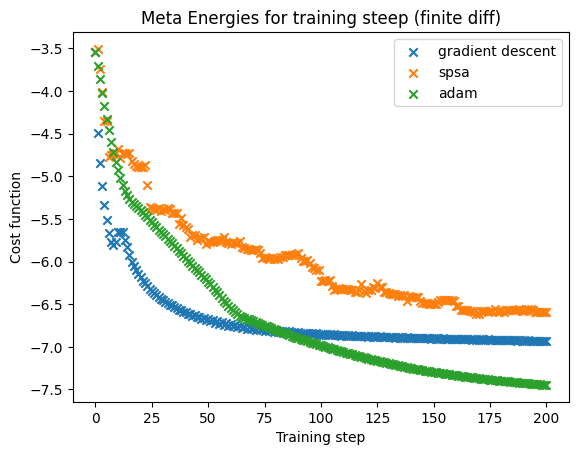

In [15]:
plt.scatter([i for i in range(len(TRAINING_ENERGIES['gradient_descent']['energies'][-1]))],TRAINING_ENERGIES['gradient_descent']['energies'][-1], label="gradient descent", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['spsa']['energies'][-1]))],TRAINING_ENERGIES['spsa']['energies'][-1], label="spsa", marker='x')
plt.scatter([i for i in range(len(TRAINING_ENERGIES['adam']['energies'][-1]))],TRAINING_ENERGIES['adam']['energies'][-1], label="adam", marker='x')

plt.legend()
plt.title('Meta Energies for training steep (finite diff)')
plt.ylabel('Cost function')
plt.xlabel('Training step')
plt.show

In [16]:
trained_energies = {"gradient_descent":[], "spsa":[], "adam":[]}

for d in test_points:
    print(d)
    for k in trained_energies:
        encoded_params = linear_encoding(TRAINING_ENERGIES[k]["trained_meta_vars"][-1], d)
        energy= catalyst_simplified_two_design(encoded_params,d)
        trained_energies[k].append(energy)

0.6


/opt/conda/envs/python39/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


0.8
1.0
1.2000000000000002
1.4000000000000004
1.6000000000000005
1.8000000000000003
2.0000000000000004
2.2000000000000006
2.400000000000001
2.600000000000001
2.8000000000000007
3.000000000000001
3.200000000000001
3.400000000000001
3.600000000000001
3.800000000000001
4.000000000000001
4.200000000000001
4.400000000000001
4.600000000000001
4.800000000000001
5.000000000000001
5.200000000000001
5.400000000000001
5.600000000000001
5.800000000000002


<function matplotlib.pyplot.show(close=None, block=None)>

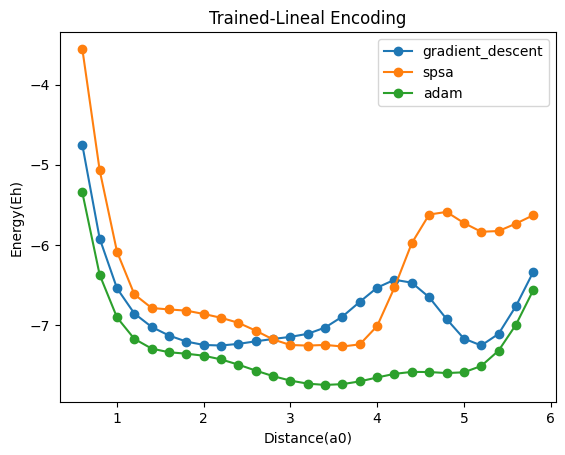

In [17]:
plt.plot(test_points, trained_energies["gradient_descent"], label="gradient_descent", marker='o')
plt.plot(test_points, trained_energies["spsa"], label="spsa", marker='o')
plt.plot(test_points, trained_energies["adam"], label="adam", marker='o')
plt.legend()
plt.title('Trained-Lineal Encoding')
plt.xlabel('Distance(a0)')
plt.ylabel('Energy(Eh)')
plt.show